<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DataAnalysis/blob/main/05.%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B8%B0%EB%B0%98%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/ch05_10_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EB%B9%84%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.10. 사이킷런 실습 - 비선형회귀분석

---
* 날짜: 2022-05-23
* 이름: 박태현

## 학습내용
    - 다항식을 이용한 회귀 분석을 진행한다.
    - 랜덤 포레스트를 이용해 비선형 회귀를 진행한다.
    - 앙상블 학습에 대해 이해한다.

```
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/딥러닝 프레임워크실무/SkillTreePython-DataAnalysis-main/05.머신러닝기반데이터분석/scripts')
from data_loader import *
from score_dict import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **선형 회귀 모델을 다항 회귀로 변환**
---

### **| 간단한 데이터에 대한 다항 회귀**

#### **데이터**
```
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0]).reshape(-1, 1)

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])
```

* 데이터 생성

In [3]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0]).reshape(-1, 1)

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

X.shape, y.shape

((10, 1), (10,))

* 시각화

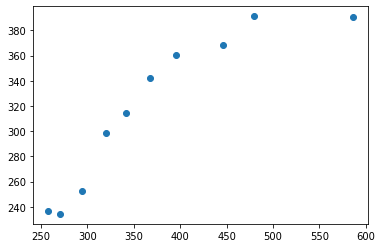

In [4]:
plt.scatter(X,y)

#### **선형 특성 학습**

In [48]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(X,y)

LinearRegression()

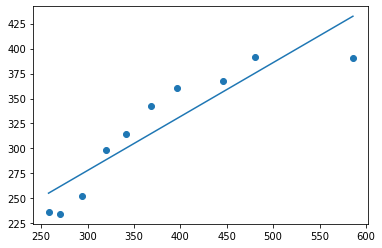

In [49]:
plt.scatter(X,y)
y_pred = lr1.predict(X)
plt.plot(X,y_pred)

#### **이차항 특성 학습**


In [50]:
from sklearn.preprocessing import PolynomialFeatures
# x가 1차항 -> 다차항으로 변환
quad = PolynomialFeatures(degree = 2) # 차수 지정

* X 데이터 변환

In [51]:
X_quad = quad.fit_transform(X)
X.shape, X_quad.shape

((10, 1), (10, 3))

In [52]:
quad.get_feature_names_out()
pd.DataFrame(X_quad, columns = quad.get_feature_names_out())

,1,x0,x0^2
0,1.0,258.0,66564.0
1,1.0,270.0,72900.0
2,1.0,294.0,86436.0
3,1.0,320.0,102400.0
4,1.0,342.0,116964.0
5,1.0,368.0,135424.0
6,1.0,396.0,156816.0
7,1.0,446.0,198916.0
8,1.0,480.0,230400.0
9,1.0,586.0,343396.0


* 학습

In [53]:
lr2 = LinearRegression()
lr2.fit(X_quad, y)

LinearRegression()

#### **테스트셋 성능 비교**

In [54]:
y_pred1 = lr1.predict(X)
lr1_socres = regression_scores(y,y_pred1)
y_pred2 = lr2.predict(X_quad)
lr2_socres = regression_scores(y,y_pred2)

pd.DataFrame([lr1_socres, lr2_socres], index = ['linear','quad'])

(10,) (10,)


,mse,rmse,mae,nmae,mape,r2
linear,569.78,23.870,21.898,0.069,7.035,0.832
quad,61.33,7.831,6.379,0.020,2.213,0.982


#### **그래프 시각화**

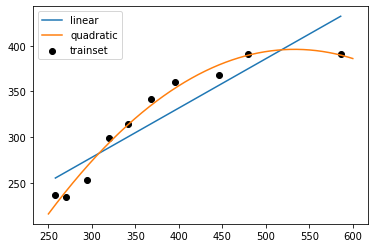

In [25]:
X_every = np.arange(250, 600, 0.1).reshape(-1,1)
plt.scatter(X,y, label = 'trainset', c='k')
plt.plot(X, lr1.predict(X), label = 'linear')
plt.plot(X_every, lr2.predict(quad.fit_transform(X_every)), label = 'quadratic')
plt.legend()
plt.show()

### **| 주택 데이터를 이용한 비선형 회귀 분석**



#### **주택 데이터셋**

[https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

    
<pre>
01. CRIM     도시의 인당 범죄율
02. ZN       2만 5,0000평방 피트가 넘는 주택 비율
03. INDUS    도시에서 소매 업종이 아닌 지역 비율
04. CHAS     찰스 강 인접 여부(강 주변=1, 그외=0)
05. NOX      일산화질소 농도(10ppm당)
06. RM       주택의 평균 방 개수
07. AGE      1940년 이전에 지어진 자가 주택 비율
08. DIS      다섯 개의 보스턴 고용 센터까지 가중치가 적용된 거리
09. RAD      방사형으로 뻗은 고속도로까지 접근성 지수
10. TAX      10만 달러당 재산세율
11. PTRATIO  도시의 학생-교사 비율
12. B        1000(Bk - 0.63)^2 도시의 아프리카계 미국인 비율
13. LSTAT    저소득층 비율
14. MEDV     자가 주택의 중간가격 (단위 $1000s)
</pre>



* 데이터 불러오기


In [26]:
X_train, X_test, y_train, y_test =housing_loader(['LSTAT']) # X 속성 선택 가능
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(506, 14)


((404, 1), (102, 1), (404,), (102,))

* 시각화

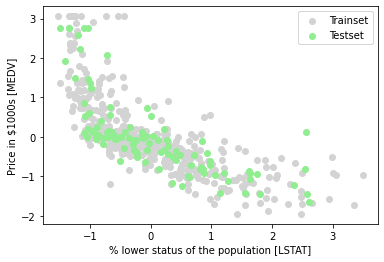

In [70]:
def draw_data():
  plt.scatter(X_train, y_train, label='Trainset', color='lightgray')
  plt.scatter(X_test, y_test, label='Testset', color='lightgreen')
  plt.xlabel('% lower status of the population [LSTAT]')
  plt.ylabel('Price in $1000s [MEDV]')
  plt.legend()
draw_data()

#### **선형 모델 학습**

In [79]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)


LinearRegression()

#### **이차 다항 모델 학습**

In [80]:
lr2 = LinearRegression()
quad = PolynomialFeatures(degree = 2)
X_quad = quad.fit_transform(X_train)
lr2.fit(X_quad, y_train)


LinearRegression()

#### **삼차 다항 모델 학습**

In [81]:
lr3 = LinearRegression()
cubic = PolynomialFeatures(degree = 3)
X_cubic = cubic.fit_transform(X_train)
lr3.fit(X_cubic, y_train)


LinearRegression()

#### **테스트셋 성능 비교**

In [82]:
# 예측
y_pred1 = lr1.predict(X_test)
y_pred2 = lr2.predict(quad.fit_transform(X_test)) # 이차항 변환
y_pred3 = lr3.predict(cubic.fit_transform(X_test)) # 삼차항 변환

# 성능 평가
lr1_scores = regression_scores(y_test,y_pred1)
lr2_scores = regression_scores(y_test,y_pred2)
lr3_scores = regression_scores(y_test,y_pred3)

# 데이터프레임으로 보기
df_scores = pd.DataFrame([lr1_scores, lr2_scores, lr3_scores], index = ['index', 'quadratic', 'cubic'])

df_scores

,mse,rmse,mae,nmae,mape,r2
index,0.463,0.680,0.501,0.721,239.529,0.537
quadratic,0.343,0.586,0.445,0.640,228.354,0.657
cubic,0.315,0.562,0.422,0.606,180.717,0.685


#### **그래프 시각화**

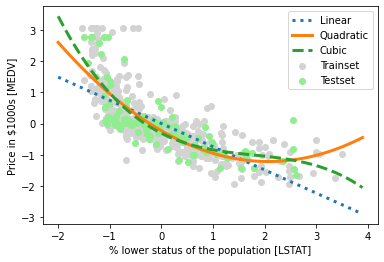

In [84]:
draw_data()

X_every = np.arange(-2, 4, 0.1).reshape(-1,1)
plt.plot(X_every, lr1.predict(X_every), 
         label='Linear',
         linewidth=3, linestyle=':') # 1차항
plt.plot(X_every, lr2.predict(quad.fit_transform(X_every)), 
         label='Quadratic',
         linewidth=3) # 2차항
plt.plot(X_every, lr3.predict(cubic.fit_transform(X_every)), 
         label='Cubic',
         linewidth=3, linestyle='--') # 3차항
plt.legend()
plt.show()

## **랜덤 포레스트를 사용하여 비선형 관계 다루기**
---

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F96F6N%2FbtqwVglgV2S%2FYTCytd7Z2egbnbJM29MJv1%2Fimg.png)

*출처:  ratsgo's blog

### **| 결정트리 회귀**

* Decision Tree

#### **모델 학습**

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=1,
                             max_depth = 3)
tree.fit(X_train, y_train)

#### **테스트셋 성능비교**

In [93]:
y_pred = tree.predict(X_test)
score = regression_scores(y_test, y_pred)
df_scores.loc['tree'] = score
df_scores.style.background_gradient(cmap = 'Blues_r')

,mse,rmse,mae,nmae,mape,r2
index,0.463000,0.680000,0.501000,0.721000,239.529000,0.537000
quadratic,0.343000,0.586000,0.445000,0.640000,228.354000,0.657000
cubic,0.315000,0.562000,0.422000,0.606000,180.717000,0.685000
tree,0.307000,0.554000,0.402000,0.578000,298.471000,0.693000


#### **그래프 시각화**

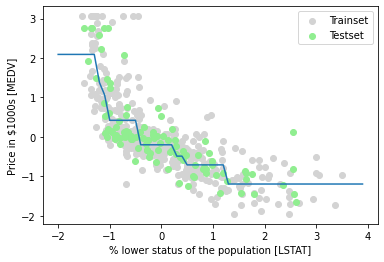

In [94]:
draw_data()

plt.plot(X_every, tree.predict(X_every))

### **| 랜덤 포레스트 회귀 (Random Forest Regressor)**

#### **모델 학습**

In [95]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state = 1)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

#### **테스트셋 성능 비교**

In [96]:
y_pred = forest.predict(X_test)
score = regression_scores(y_test, y_pred)
df_scores.loc['forest'] = score
df_scores.style.background_gradient(cmap = 'Blues_r')

,mse,rmse,mae,nmae,mape,r2
index,0.463000,0.680000,0.501000,0.721000,239.529000,0.537000
quadratic,0.343000,0.586000,0.445000,0.640000,228.354000,0.657000
cubic,0.315000,0.562000,0.422000,0.606000,180.717000,0.685000
tree,0.307000,0.554000,0.402000,0.578000,298.471000,0.693000
forest,0.439000,0.663000,0.476000,0.685000,155.811000,0.561000


#### **그래프 시각화**

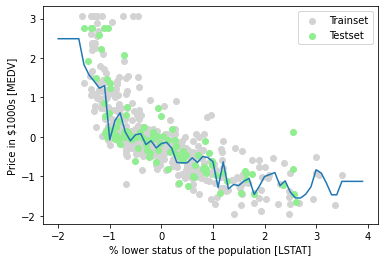

In [98]:
draw_data()

plt.plot(X_every, forest.predict(X_every))

### **| 엑스트라 트리 (Extra Tree Regressor)**

#### **모델 학습**

In [99]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(random_state=1)
et.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

#### **테스트셋 성능 비교**

In [100]:
y_pred = et.predict(X_test)
score = regression_scores(y_test, y_pred)
df_scores.loc['et'] = score
df_scores.style.background_gradient(cmap = 'Blues_r')

,mse,rmse,mae,nmae,mape,r2
index,0.463000,0.680000,0.501000,0.721000,239.529000,0.537000
quadratic,0.343000,0.586000,0.445000,0.640000,228.354000,0.657000
cubic,0.315000,0.562000,0.422000,0.606000,180.717000,0.685000
tree,0.307000,0.554000,0.402000,0.578000,298.471000,0.693000
forest,0.439000,0.663000,0.476000,0.685000,155.811000,0.561000
et,0.438000,0.662000,0.477000,0.686000,139.622000,0.562000


#### **그래프 시각화**

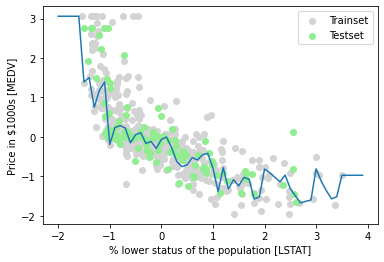

In [101]:
draw_data()

plt.plot(X_every, et.predict(X_every))

### **| Gradient Boosting Regressor**

#### **모델 학습**

In [102]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state = 1)
gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

#### **테스트셋 성능 비교**

In [103]:
y_pred = gb.predict(X_test)
score = regression_scores(y_test, y_pred)
df_scores.loc['gb'] = score
df_scores.style.background_gradient(cmap = 'Blues_r')

,mse,rmse,mae,nmae,mape,r2
index,0.463000,0.680000,0.501000,0.721000,239.529000,0.537000
quadratic,0.343000,0.586000,0.445000,0.640000,228.354000,0.657000
cubic,0.315000,0.562000,0.422000,0.606000,180.717000,0.685000
tree,0.307000,0.554000,0.402000,0.578000,298.471000,0.693000
forest,0.439000,0.663000,0.476000,0.685000,155.811000,0.561000
et,0.438000,0.662000,0.477000,0.686000,139.622000,0.562000
gb,0.336000,0.580000,0.409000,0.588000,95.064000,0.664000


#### **그래프 시각화**

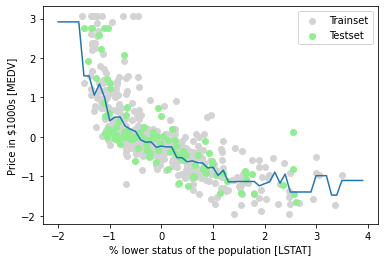

In [107]:
draw_data()

plt.plot(X_every, gb.predict(X_every))

### **| XGBoost Regressor**

#### **모델 학습**

In [105]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

[05:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=1)

#### **테스트셋 성능 비교**

In [108]:
y_pred = xgb.predict(X_test)
score = regression_scores(y_test, y_pred)
df_scores.loc['xgb'] = score
df_scores.style.background_gradient(cmap = 'Blues_r')

,mse,rmse,mae,nmae,mape,r2
index,0.463000,0.680000,0.501000,0.721000,239.529000,0.537000
quadratic,0.343000,0.586000,0.445000,0.640000,228.354000,0.657000
cubic,0.315000,0.562000,0.422000,0.606000,180.717000,0.685000
tree,0.307000,0.554000,0.402000,0.578000,298.471000,0.693000
forest,0.439000,0.663000,0.476000,0.685000,155.811000,0.561000
et,0.438000,0.662000,0.477000,0.686000,139.622000,0.562000
gb,0.336000,0.580000,0.409000,0.588000,95.064000,0.664000
xgb,0.322000,0.567000,0.400000,0.574000,85.381000,0.678000


#### **그래프 시각화**

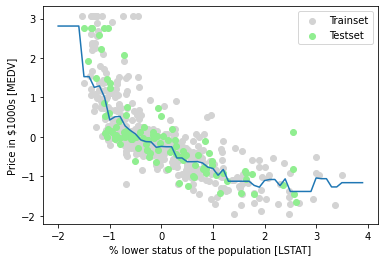

In [109]:
draw_data()

plt.plot(X_every, xgb.predict(X_every))

## **과제1: 주택 데이터셋 다중 회귀 분석**
---

* 주택 데이터셋의 X의 모든 속성을 이용해 y를 예측합니다.
* 지난시간과 이번시간에 배운 회귀 분석 모델을 모두 사용해보고, 성능을 비교해 봅니다.
* 단, 다항회귀는 사용하지 마세요.
* 사용 모델 : 
```
'linear', 'ridge', 'lasso', 'elastic', 'bayes_ridge', 'tree', 'forest', 'et', 'gb', 'xgb'
```

#### **데이터 불러오기**

In [110]:
X_train, X_test, y_train, y_test = housing_loader() # X 속성 선택 가능
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(506, 14)


((404, 13), (102, 13), (404,), (102,))

* 분석 예시

[05:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


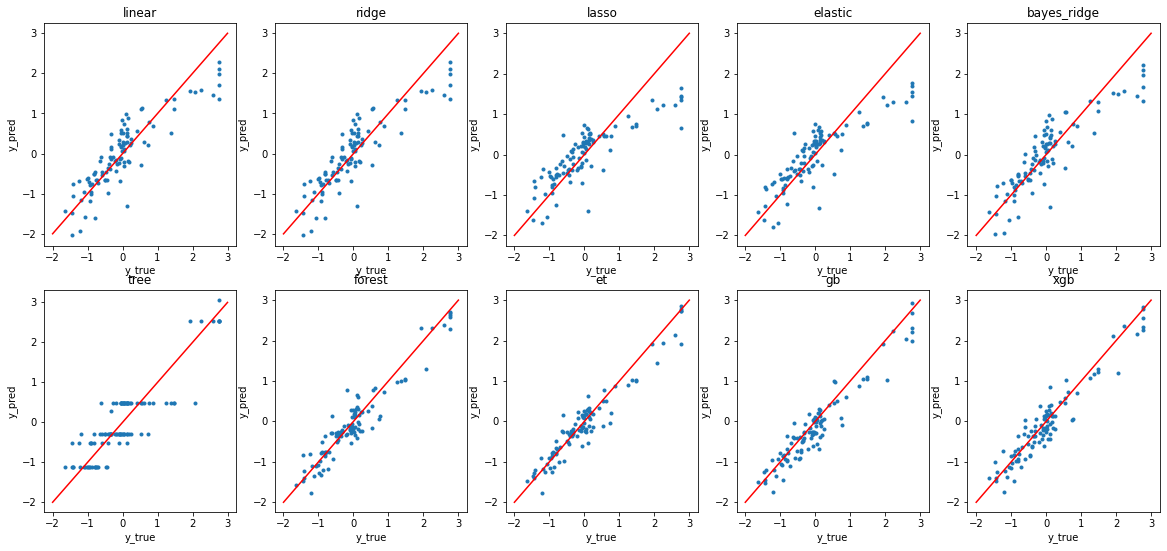

,mse,rmse,mae,nmae,mape,r2
linear,0.222000,0.471000,0.362000,0.521000,198.397000,0.778000
ridge,0.222000,0.471000,0.362000,0.520000,198.722000,0.778000
lasso,0.315000,0.561000,0.421000,0.606000,188.638000,0.685000
elastic,0.280000,0.529000,0.399000,0.573000,211.990000,0.720000
bayes_ridge,0.220000,0.469000,0.359000,0.516000,212.854000,0.780000
tree,0.218000,0.467000,0.378000,0.543000,323.084000,0.782000
forest,0.095000,0.308000,0.234000,0.336000,93.510000,0.905000
et,0.079000,0.282000,0.206000,0.297000,85.360000,0.921000
gb,0.105000,0.324000,0.246000,0.353000,60.484000,0.895000
xgb,0.091000,0.301000,0.236000,0.339000,149.109000,0.909000


In [116]:
from sklearn.linear_model import *
linear = LinearRegression()
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)
elastic = ElasticNet(alpha = 0.1)
bayes_ridge = BayesianRidge()

df_score = pd.DataFrame()

plt.figure(figsize=(20,9))
for idx, model in enumerate(['linear', 'ridge', 'lasso', 'elastic', 'bayes_ridge', 
                             'tree', 'forest', 'et', 'gb', 'xgb']):
  # 모델별 학습 및 예측
  eval(model).fit(X_train, y_train)
  y_pred = eval(model).predict(X_test)
  
  # 실제-예측 산점도
  plt.subplot(2,5,idx+1)
  plt.title(model)
  plt.scatter(y_test, y_pred, marker='.')
  plt.plot([-2,3],[-2,3], c='r')
  plt.xlabel('y_true')
  plt.ylabel('y_pred')
  
  # 성능 평가
  df_score = pd.concat([df_score, pd.DataFrame(regression_scores(y_test, y_pred) ,index=[model]) ])

plt.show()
df_score.style.background_gradient(cmap = 'Blues_r')

## **과제2: 해외 축구 선수 이적료 예측 미션**
---

* https://dacon.io/competitions/open/235538/overview/description
* 수업 시간에 배운 내용들을 적용하여 이적료 예측을 진행하고 리더보드에 결과를 제출합니다.

In [123]:
df1 = pd.read_csv('/content/FIFA_train.csv')
df2 = pd.read_csv('/content/FIFA_test.csv')
df1.shape, df2.shape

((8932, 12), (3828, 11))

In [119]:
df1.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [124]:
df2.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [125]:
df2.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

In [126]:
df1['value'].shape

(8932,)